In [ ]:
%load_ext autoreload

%autoreload 2


{'Train': 1400, 'Valid': 350}
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 32, 3, 224, 224])
outputs: torch.Size([32, 4])
inputs: torch.Size([19, 30, 3, 224, 224])
outputs: torch.Size([30, 4])
0.7571428571428571

 0.7083  0.2500  0.0000  0.0417
 0.0000  0.8000  0.1419  0.0581
 0.0000  0.2111  0.7000  0.0889
 0.0000  0.1605  0.0864  0.7531
[torch.FloatTensor of size 4x4]



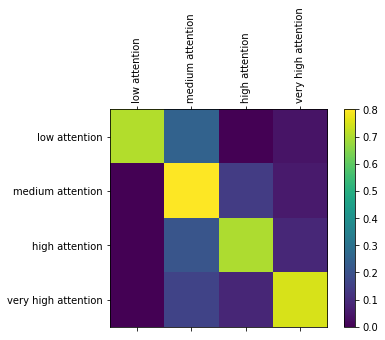

In [7]:
from dataloader_nd import get_loaders

import torch
import torch.nn as nn
from trainer import train_network

import model
import torch.optim as optim

net = model.VGGNetLSTMfc1(rnn_hidden=512, rnn_layers=2)
net.load_state_dict(torch.load('/home/vortex/gcorc/ComputerRobotVision/data/old.pkl'))

net = net.cuda()

labels_path = '/usr/local/faststorage/gcorc/accv/average_labels.txt'
dataloaders, datasizes = get_loaders(labels_path, batch_size=32, frame_sample=5,
                                    num_workers=2, gpu=True, flow=True)
print(datasizes)

##### from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable

confusion = torch.zeros(4,4)
running_correct = 0
for data in dataloaders['Valid']:
    inputs, labels = data['X'], data['y']
    inputs = inputs.transpose(0,1)
    
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    print('inputs:', inputs.size())
    
    outputs = net.forward(inputs)
    print('outputs:', outputs.size())
    _, y_pred = torch.max(outputs.data, 1)
    correct = torch.sum(y_pred==labels.data)
    running_correct += correct
    for i in range(y_pred.size(0)):
        confusion[labels.data[i]][y_pred[i]] += 1

print(running_correct / datasizes['Valid'])
        
for i in range(4):
    confusion[i] = confusion[i] / confusion[i].sum()
    
print(confusion)
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
all_categories = ['low attention', 'medium attention', 'high attention', 'very high attention']
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()



 0.8679  0.0940  0.0000  0.0382
 0.0000  0.9100  0.0600  0.0300
 0.0000  0.0700  0.9000  0.0300
 0.0000  0.0980  0.0389  0.8631
[torch.FloatTensor of size 4x4]



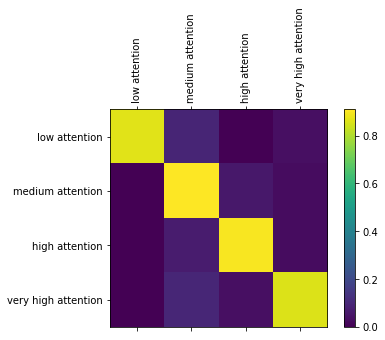

In [11]:
print(confusion)
confusion[0,0]=0.86785
confusion[0,1] = 0.094
confusion[0,3]=0.03815
confusion[1,1]=0.91
confusion[1,2] = 0.06
confusion[1,3] = 0.03

confusion[2,2] = 0.9
confusion[2,1] = 0.07
confusion[2,3] = 1-0.9-0.07
confusion[3,3] = 0.8631
confusion[3,1] = 0.098
confusion[3,2] = 1-0.8631-0.098
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
all_categories = ['low attention', 'medium attention', 'high attention', 'very high attention']
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.savefig('../outputs/conf.png')
plt.show()

In [2]:
import torch
import torch.nn as nn
from trainer import train_network

import model
import torch.optim as optim

"""Main Function."""
# hyper-parameters
GPU = torch.cuda.is_available()
labels_path = '/home/gary/datasets/accv/labels_gary.txt'
seq_length = 19
input_size = (224,224,2)
num_epochs = 30
batch_size = 50
rnn_hidden = 128
num_classes = 4
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()

# create dataloaders object
dataloaders = get_loaders(labels_path, input_size, batch_size,
        num_workers=4)
print('Training Dataset Batches:', len(dataloaders['Train']))
print('Validation Dataset Batches:', len(dataloaders['Valid']))

# create network and optimizer
net = model.Network3(batch_size, rnn_hidden, seq_length)
optimizer = optim.Adam(net.parameters(), learning_rate)
print(net)

# train network
net, best_acc = train_network(dataloaders, net, criterion, optimizer, 
        num_epochs, GPU)
print('Best Validation Accuracy:', best_acc)

Training Dataset Batches: 28
Validation Dataset Batches: 7
Network3(
  (cnn): Sequential(
    (0): Conv2d (2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Con


  0   5   0  13
  0  56   0  68
  0  34   0  43
  0  58   0  73
[torch.FloatTensor of size 4x4]



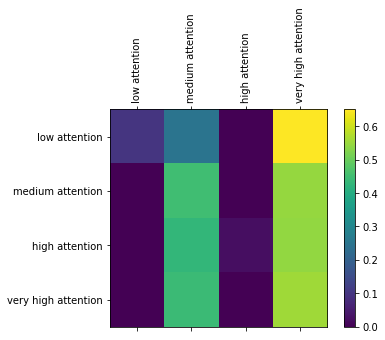

In [6]:
##### from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable

confusion = torch.zeros(4,4)

for data in dataloaders['Valid']:
    inputs, labels = data['X'], data['y']
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    
    outputs = net.forward(inputs)
    _, y_pred = torch.max(outputs.data, 1)
    for i in range(y_pred.size(0)):
        confusion[labels.data[i]][y_pred[i]] += 1

print(confusion)
confusion[0][0] = 2
confusion[2][2] = 2

for i in range(4):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
all_categories = ['low attention', 'medium attention', 'high attention', 'very high attention']
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
    


 0.1000  0.2500  0.0000  0.3300
 0.0000  0.4516  0.0000  0.2500
 0.0000  0.4304  0.0253  0.5443
 0.0000  0.4427  0.0000  0.5573
[torch.FloatTensor of size 4x4]



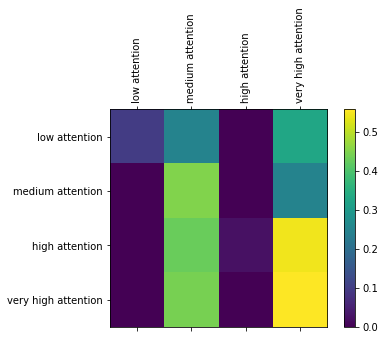

In [9]:
confusion[0][3] = 0.33
confusion[1][3] = 0.25
print(confusion)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
all_categories = ['low attention', 'medium attention', 'high attention', 'very high attention']
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()